In [1]:
import psycopg2
import os
import sys
import pandas as pd
import pandas.io.sql as sqlio
import datetime
sys.path.append(os.path.dirname(os.getcwd()))
import matplotlib.pyplot as plt

In [2]:
from pipeline import populate_dwh

In [3]:
redshift = {'DWH_DB_USER':os.environ['DWH_DB_USER'],
    'DWH_DB_PASSWORD':os.environ['DWH_DB_PASSWORD'],
    'DWH_ENDPOINT':os.environ['DWH_ENDPOINT'],
    'DWH_PORT':'5439',
    'DWH_DB':'dev',
    'DWH_IAM_ROLE': os.environ['DWH_IAM_ROLE']}

## Check load results

In [4]:
conn_string = "postgresql://{}:{}@{}:{}/{}".format(redshift['DWH_DB_USER'], redshift['DWH_DB_PASSWORD'], redshift['DWH_ENDPOINT'], redshift['DWH_PORT'],redshift['DWH_DB'])
con = psycopg2.connect(conn_string)

In [5]:
tweet_cnt = sqlio.read_sql_query(f"select distinct keyword_date, count(1) from mapping_table group by keyword_date", con)
tweet_cnt

/var/folders/th/flmj2p9x5s12x8nk19d3zbwr0000gn/T/ipykernel_67276/4265129869.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tweet_cnt = sqlio.read_sql_query(f"select distinct keyword_date, count(1) from mapping_table group by keyword_date", con)


,keyword_date,count
0,ChatGPT_2023-02-18,4979
1,ChatGPT_2023-02-16,4974
2,Ohio_2023-02-15,4971
3,Layoff_2023-02-15,465
4,Layoff_2023-02-19,219
5,Ohio_2023-02-18,4975
6,Layoff_2023-02-18,206
7,Ohio_2023-02-17,4983
8,ChatGPT_2023-02-14,4971
9,Ohio_2023-02-14,4973


## Get corresponding from facts table

In [6]:
#fact table
query = f'''
SELECT * FROM fact_tweets t1
join (
select tweet_id from mapping_table where keyword_date = 'ChatGPT_2023-02-14' GROUP BY tweet_id
) t2
on t1.tweet_id = t2.tweet_id
'''
fact_tweets = sqlio.read_sql_query(query, con)
fact_tweets.head()

/var/folders/th/flmj2p9x5s12x8nk19d3zbwr0000gn/T/ipykernel_67276/1985653245.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fact_tweets = sqlio.read_sql_query(query, con)


,tweet_id,possibly_sensitive,dt,place_id,user_id,is_edited,text,retweet_cnt,reply_cnt,like_cnt,quote_cnt,impression_cnt,tweet_id
0,1625645960675176448,False,2023-02-14 23:59:34,None,16357285,False,Can You Protect Your IP in the Age of ChatGPT?...,0,0,0,0,19,1625645960675176448
1,1625645763714813952,False,2023-02-14 23:58:47,None,1545376560986918912,False,"You can't beat ChatGPT 😂, Bard AI, You're not ...",0,0,0,0,29,1625645763714813952
2,1625645707897233409,False,2023-02-14 23:58:34,None,17223501,False,What DevOps Needs to Know About ChatGPT https:...,1,0,0,0,18,1625645707897233409
3,1625645701081481217,False,2023-02-14 23:58:32,None,1365173420019781636,False,I just spoke with a college student who used C...,0,2,12,0,591,1625645701081481217
4,1625645384960983041,False,2023-02-14 23:57:17,None,216103914,False,These companies aren’t doing a good job of sel...,1,2,4,0,764,1625645384960983041


## How many tweets are sensitive

In [7]:
fact_tweets.possibly_sensitive.value_counts()

False    4927
True       44
Name: possibly_sensitive, dtype: int64

## Most popular tweets

In [8]:
fact_tweets.sort_values(by = 'impression_cnt', ascending = False).head(10)

,tweet_id,possibly_sensitive,dt,place_id,user_id,is_edited,text,retweet_cnt,reply_cnt,like_cnt,quote_cnt,impression_cnt,tweet_id
2950,1625611360967983104,False,2023-02-14 21:42:05,None,31586578,False,What is ChatGPT doing ... and why does it work...,1355,73,5554,198,843270,1625611360967983104
3618,1625575747401441280,False,2023-02-14 19:20:34,None,1319101874532978690,False,Personal update: after two years at @Google Br...,125,93,3434,39,426361,1625575747401441280
2308,1625548670585258003,False,2023-02-14 17:32:58,None,15827269,False,Welcome @rachelmetz to the Bloomberg @technolo...,12,7,189,6,361588,1625548670585258003
4125,1625583734086045696,False,2023-02-14 19:52:18,None,1357426015312760834,False,Excited to share that I joined @OpenAI after ...,47,36,1242,12,232951,1625583734086045696
2440,1625540413078786048,False,2023-02-14 17:00:10,None,30325257,False,#AI #crypto coins have been all the buzz recen...,91,73,385,5,178735,1625540413078786048
3304,1625591583772135425,False,2023-02-14 20:23:30,None,16813044,False,"In a stunning turn of events, ChatGPT inaccura...",361,164,2086,41,154059,1625591583772135425
1882,1625543249493360640,False,2023-02-14 17:11:26,None,1524901467689078789,False,AI / ChatGPT Prompting Tip:\n\nThe best prompt...,111,60,940,9,146983,1625543249493360640
2592,1625634233799548929,False,2023-02-14 23:12:58,None,19304217,False,Getting marginally depressed thinking about al...,54,35,728,8,117737,1625634233799548929
2265,1625551746427748355,False,2023-02-14 17:45:12,None,51241574,False,"Like the calculator, spellcheck and Google bef...",28,14,51,5,115715,1625551746427748355
3400,1625585730754846720,False,2023-02-14 20:00:14,None,47504804,False,What does China's AI industry think about Chat...,60,9,201,3,115184,1625585730754846720


## Distribution of impression count

(array([2.133e+03, 7.320e+02, 3.950e+02, 2.510e+02, 1.420e+02, 1.280e+02,
        1.010e+02, 8.300e+01, 6.700e+01, 4.800e+01, 5.000e+01, 4.000e+01,
        3.800e+01, 2.700e+01, 2.900e+01, 2.300e+01, 3.300e+01, 2.200e+01,
        1.500e+01, 1.300e+01, 1.100e+01, 1.700e+01, 9.000e+00, 1.700e+01,
        1.500e+01, 1.600e+01, 6.000e+00, 1.200e+01, 1.200e+01, 1.200e+01,
        9.000e+00, 1.200e+01, 8.000e+00, 8.000e+00, 6.000e+00, 4.000e+00,
        2.000e+00, 1.100e+01, 2.000e+00, 8.000e+00, 1.000e+01, 2.000e+00,
        5.000e+00, 7.000e+00, 8.000e+00, 7.000e+00, 7.000e+00, 0.000e+00,
        4.000e+00, 8.000e+00]),
 array([   0.  ,   39.76,   79.52,  119.28,  159.04,  198.8 ,  238.56,
         278.32,  318.08,  357.84,  397.6 ,  437.36,  477.12,  516.88,
         556.64,  596.4 ,  636.16,  675.92,  715.68,  755.44,  795.2 ,
         834.96,  874.72,  914.48,  954.24,  994.  , 1033.76, 1073.52,
        1113.28, 1153.04, 1192.8 , 1232.56, 1272.32, 1312.08, 1351.84,
        1391.6 , 1431

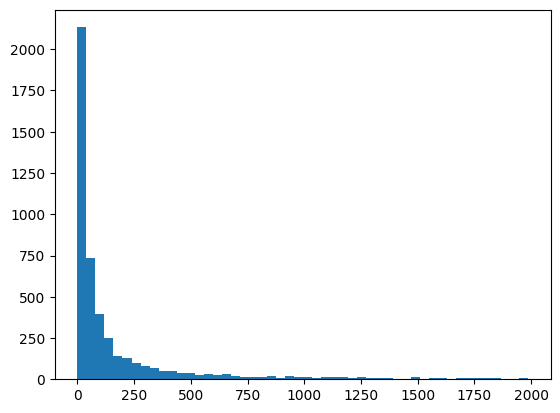

In [9]:
plt.hist(fact_tweets['impression_cnt'][fact_tweets['impression_cnt']<2000],bins = 50)

## Distribution of tweets length

(array([  4.,  14.,  12.,  34.,  37.,  89.,  62., 125., 117., 171., 155.,
        232., 151., 224., 165., 169., 149., 161., 151., 157., 132., 119.,
         93.,  96.,  77.,  95., 103.,  81.,  83.,  61.,  68.,  77.,  84.,
        102., 126.,  88.,  97., 100.,  96.,  83., 172., 250.,  50.,  38.,
        102.,  92.,   6.,   3.,  10.,   8.]),
 array([  7.  ,  13.52,  20.04,  26.56,  33.08,  39.6 ,  46.12,  52.64,
         59.16,  65.68,  72.2 ,  78.72,  85.24,  91.76,  98.28, 104.8 ,
        111.32, 117.84, 124.36, 130.88, 137.4 , 143.92, 150.44, 156.96,
        163.48, 170.  , 176.52, 183.04, 189.56, 196.08, 202.6 , 209.12,
        215.64, 222.16, 228.68, 235.2 , 241.72, 248.24, 254.76, 261.28,
        267.8 , 274.32, 280.84, 287.36, 293.88, 300.4 , 306.92, 313.44,
        319.96, 326.48, 333.  ]),
 <BarContainer object of 50 artists>)

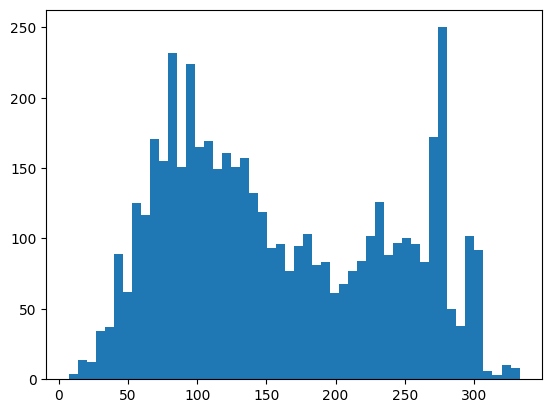

In [10]:
fact_tweets['len'] = fact_tweets['text'].str.len()
plt.hist(fact_tweets['len'],bins = 50)

## locations

In [11]:
query = '''
SELECT t2.country,count(t1.tweet_id) as cnt
from fact_tweets t1
join dim_places t2 on t1.place_id = t2.place_id
group by t2.country
'''
location_cnt = sqlio.read_sql_query(query, con)
location_cnt.sort_values(by = 'cnt', ascending = False).head(10)

/var/folders/th/flmj2p9x5s12x8nk19d3zbwr0000gn/T/ipykernel_67276/209676758.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  location_cnt = sqlio.read_sql_query(query, con)


,country,cnt
3,United States,783
5,United Kingdom,51
7,India,42
35,Canada,36
14,Australia,11
41,Spain,9
0,Nigeria,8
6,United Arab Emirates,7
45,Germany,7
37,France,6


## Sentiment Analysis

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
fact_tweets['pos_score'] = fact_tweets['text'].apply(lambda x: sia.polarity_scores(x)['pos'])
fact_tweets['neg_score'] = fact_tweets['text'].apply(lambda x: sia.polarity_scores(x)['neg'])

(array([3.449e+03, 6.000e+00, 5.000e+01, 1.340e+02, 1.160e+02, 1.220e+02,
        1.060e+02, 8.700e+01, 8.200e+01, 8.600e+01, 1.010e+02, 5.300e+01,
        4.800e+01, 4.800e+01, 5.100e+01, 4.500e+01, 4.600e+01, 8.700e+01,
        4.600e+01, 2.500e+01, 2.000e+01, 1.900e+01, 2.000e+01, 1.600e+01,
        2.000e+01, 6.000e+00, 1.100e+01, 1.000e+01, 6.000e+00, 6.000e+00,
        9.000e+00, 6.000e+00, 6.000e+00, 4.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.    , 0.0131, 0.0262, 0.0393, 0.0524, 0.0655, 0.0786, 0.0917,
        0.1048, 0.1179, 0.131 , 0.1441, 0.1572, 0.1703, 0.1834, 0.1965,
        0.2096, 0.2227, 0.2358, 0.2489, 0.262 , 0.2751, 0.2882, 0.3013,
        0.3144, 0.3275, 0.3406, 0.3537, 0.3668, 0.3799, 0.393 , 0.4061,
        0.4192, 0.4323, 0.4454, 0.4585, 0.4716, 0.4847, 0.4978, 0.5109,
        0.524 , 

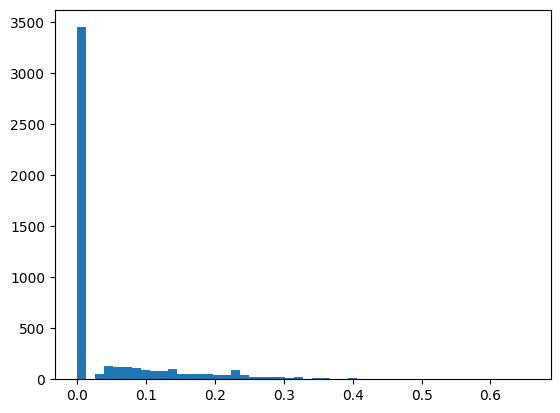

In [14]:
plt.hist(fact_tweets['neg_score'],bins = 50)

(array([2.093e+03, 5.000e+00, 4.000e+01, 1.200e+02, 1.910e+02, 1.610e+02,
        1.680e+02, 1.770e+02, 1.700e+02, 2.230e+02, 1.850e+02, 2.210e+02,
        1.290e+02, 1.270e+02, 1.170e+02, 7.400e+01, 1.140e+02, 6.400e+01,
        7.700e+01, 8.400e+01, 5.400e+01, 6.800e+01, 4.500e+01, 3.800e+01,
        3.800e+01, 2.700e+01, 2.800e+01, 1.900e+01, 1.900e+01, 1.200e+01,
        2.100e+01, 8.000e+00, 7.000e+00, 1.400e+01, 7.000e+00, 4.000e+00,
        3.000e+00, 5.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.     , 0.01436, 0.02872, 0.04308, 0.05744, 0.0718 , 0.08616,
        0.10052, 0.11488, 0.12924, 0.1436 , 0.15796, 0.17232, 0.18668,
        0.20104, 0.2154 , 0.22976, 0.24412, 0.25848, 0.27284, 0.2872 ,
        0.30156, 0.31592, 0.33028, 0.34464, 0.359  , 0.37336, 0.38772,
        0.40208, 0.41644, 0.4308 , 0.44516, 0.45952, 0.47388, 0.48824,
        0.5026 , 0.51

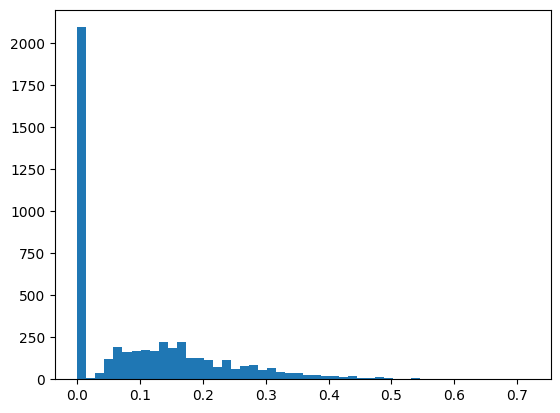

In [15]:
plt.hist(fact_tweets['pos_score'],bins = 50)